# **Klasifikasi Rempah Rimpang (Jahe, Kunyit, Kencur, dan Lengkuas) Serta Membandingkan Pre-trained Model MobileNetV1 dan MobileNetV2**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan Jahe, Kunyit, Kencur, dan Lengkuas. Dan membandingkan 2 arsitektur transfer learning MobileNetV1 dan MobileNetV2.

## **Sumber Dataset**
Data primer

# **Import Libraries**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
from PIL import Image
import skimage
from skimage import io
from skimage import img_as_ubyte

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import time
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [3]:
# menghubungkan dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Meng ekstrak file datarempah.zip
local_zip = '/content/drive/MyDrive/datasetrempah.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/')
zip_ref.close()

#### **Mempersiapkan Dataset**

In [5]:
data_dir = '/content/datasetrempah'
target_size = (224, 224)

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(data_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

df.groupby(['labels']).size()

df.head()

path            file_name  \
0  /content/datasetrempah/lengkuas/20250509_10533...  20250509_105334.jpg   
1  /content/datasetrempah/lengkuas/20250510_09171...  20250510_091713.jpg   
2  /content/datasetrempah/lengkuas/20250509_10514...  20250509_105145.jpg   
3  /content/datasetrempah/lengkuas/20250510_09205...  20250510_092052.jpg   
4  /content/datasetrempah/lengkuas/20250510_09201...  20250510_092018.jpg   

     labels  
0  lengkuas  
1  lengkuas  
2  lengkuas  
3  lengkuas  
4  lengkuas

### **Plot distribusi gambar di seluruh kelas**

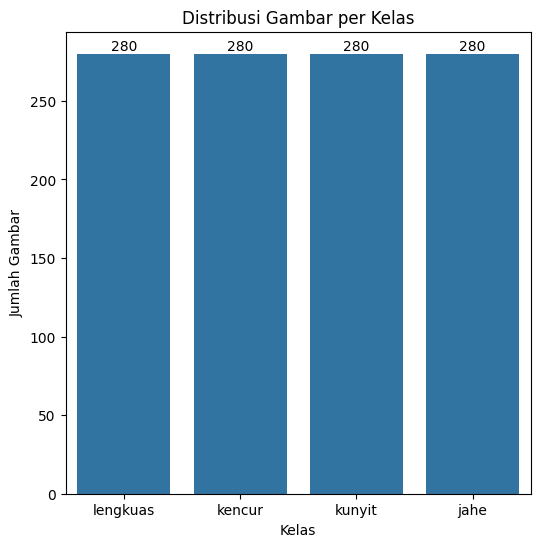

In [6]:
# Plot the distribution of images across the classes
plt.figure(figsize=(6,6))
ax = sns.countplot(x=df['labels'], data=df)

# annotasi angka di atas setiap bar
for p in ax.patches:
    h = int(p.get_height())
    ax.annotate(h, (p.get_x()+p.get_width()/2, h),
                ha='center', va='bottom')

plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Gambar per Kelas')
plt.show()

### **Plot gambar sampel untuk semua kelas**

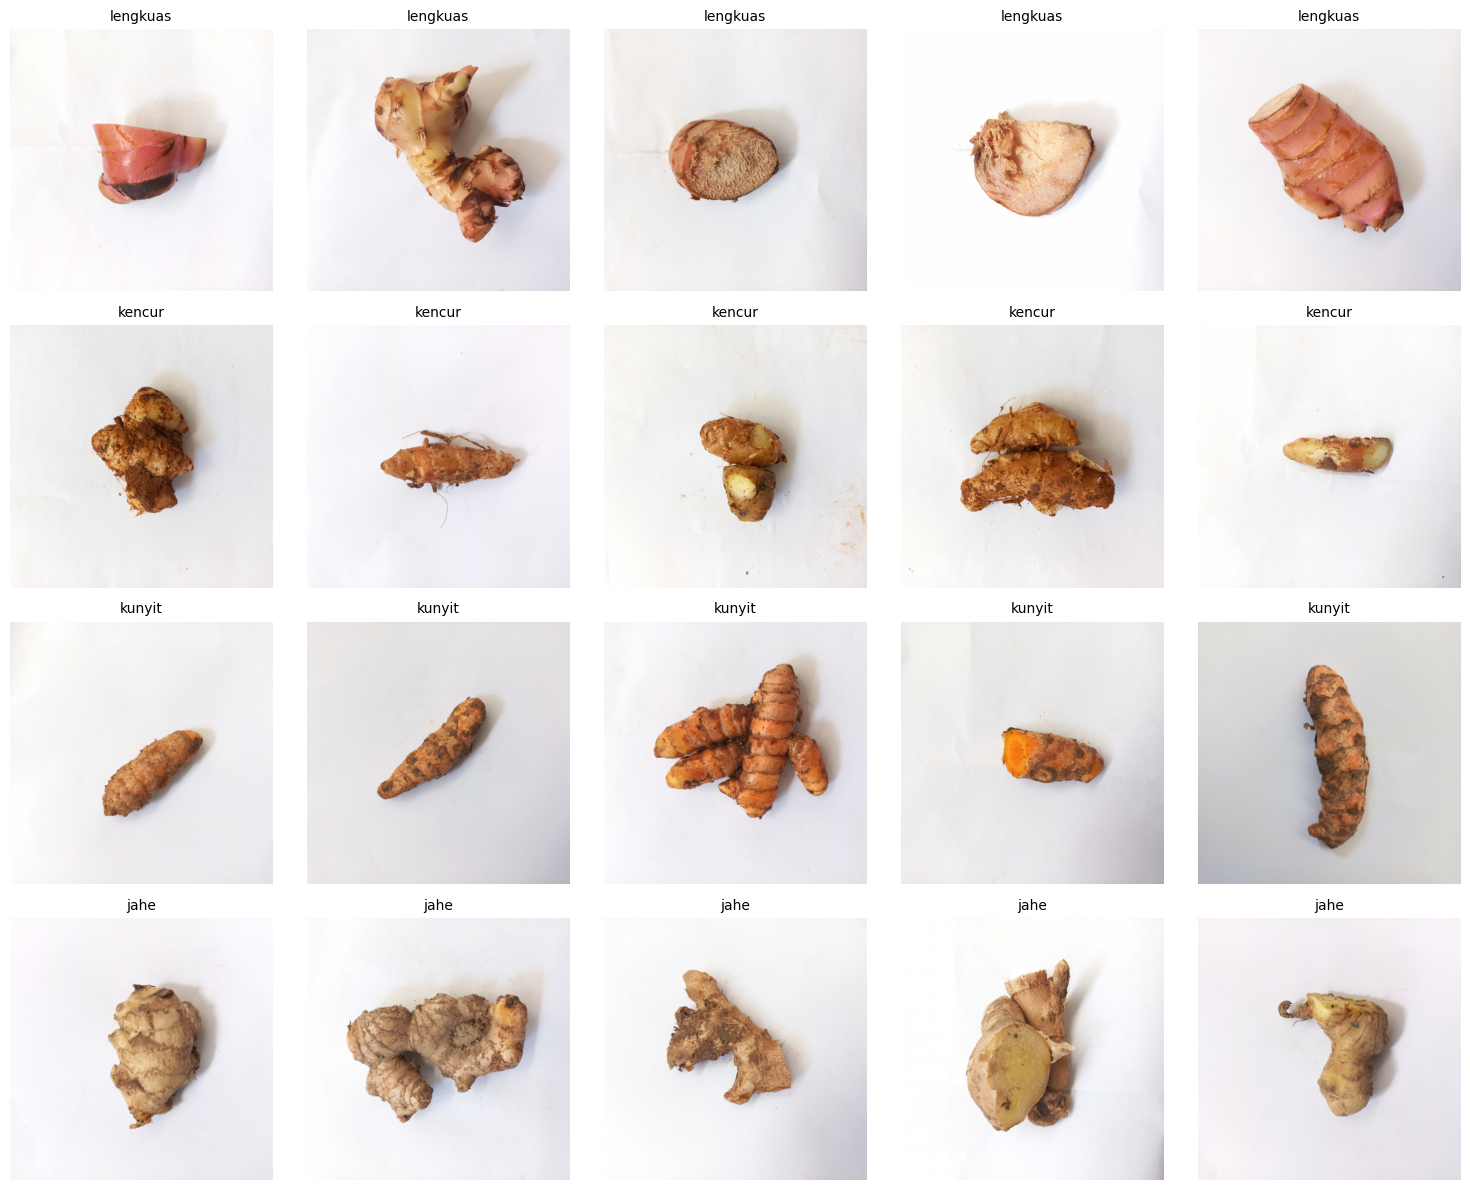

In [7]:
# Buat kamus nama kelas → list nama file
dataset_dir = "datasetrempah"
spices_images = {}
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    if os.path.isdir(category_dir):
        spices_images[category] = os.listdir(category_dir)

# Siapkan plot: baris = jumlah kelas, kolom = 5 gambar
n_classes = len(spices_images)
fig, axs = plt.subplots(n_classes, 5, figsize=(15, 3 * n_classes))

# Tampilkan 5 gambar acak per kelas
for i, (category, files) in enumerate(spices_images.items()):
    # pilih 5 nama file acak tanpa penggantian
    samples = np.random.choice(files, 5, replace=False)
    for j, nama_file in enumerate(samples):
        img_path = os.path.join(dataset_dir, category, nama_file)
        img = Image.open(img_path).convert("RGB")

        ax = axs[i, j] if n_classes > 1 else axs[j]
        ax.imshow(img)
        ax.set_title(category, fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.show()

### **Label Encoder**

In [8]:
# Label encoder

le = LabelEncoder()
le.fit(df['labels'])
df['labels'] = le.transform(df['labels'])

In [9]:
# melihat daftar kelas dan mappingnya
label_list = { code: label for code, label in enumerate(le.classes_) }
print(label_list)

{0: 'jahe', 1: 'kencur', 2: 'kunyit', 3: 'lengkuas'}


# **Data Splitting : Training and Testing**

In [10]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan data temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Membagi data sementara sebanyak 50% menjadi valid dan test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [11]:
# menyatukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train,
                         'labels':y_train,
                         'set':'train'})

df_test = pd.DataFrame({'path':X_test,
                        'labels':y_test,
                        'set':'test'})

df_val = pd.DataFrame({'path':X_valid,
                       'labels':y_valid,
                       'set':'validation'})

df_all = pd.concat([df_train, df_test, df_val]).reset_index(drop=True)

print('Total image          : ', len(df_all))
print('Total train image    : ', len(df_train))
print('Total test image     : ', len(df_test))
print('Total validasi image : ', len(df_val))

Total image          :  1120
Total train image    :  896
Total test image     :  112
Total validasi image :  112


In [12]:
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set         labels
test        0          28
            1          28
            2          28
            3          28
train       0         224
            1         224
            2         224
            3         224
validation  0          28
            1          28
            2          28
            3          28
dtype: int64 


                                                  path  labels    set
261  /content/datasetrempah/kencur/20250511_084606.jpg       1  train
528  /content/datasetrempah/kencur/20250511_090828.jpg       1  train
2    /content/datasetrempah/lengkuas/20250510_09242...       3  train
98   /content/datasetrempah/kunyit/20250511_070331.jpg       2  train
134    /content/datasetrempah/jahe/20250511_080849.jpg       0  train


In [13]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/datasetrempah"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "dataset/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
      lbl_str = le.inverse_transform([row['labels']])[0]
      file_path = os.path.join(datasource_path,lbl_str,row['image'].split('.')[0])

    # Buat direktori tujuan folder
    lbl_str = le.inverse_transform([row['labels']])[0]
    if os.path.exists(os.path.join(dataset_path,row['set'],lbl_str)) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],lbl_str))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],lbl_str,destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **DATA PROCESSING**

In [14]:
# Melakukan one-hot encoding pada label

y_train = to_categorical(y_train, num_classes=4)
y_valid = to_categorical(y_valid, num_classes=4)
y_test  = to_categorical(y_test,  num_classes=4)

### **Data Augmentasi**

In [15]:
# Create an ImageDataGenerator object normalizing the images
# training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,             # Rotasi acak hingga 20°
    brightness_range=(0.5, 1.5),   # Delta kecerahan acak antara 50%–150%
    shear_range=0.2,               # Shear (warp) acak
    width_shift_range=0.2,         # Pergeseran horizontal 20%
    height_shift_range=0.2,        # Pergeseran vertikal 20%
    vertical_flip=True,            # Flip atas-bawah
    zoom_range=0.3,                # Zoom acak hingga 30%
    fill_mode='nearest'            # Pengisian piksel baru setelah transformasi
)

# validation set, hanya rescale
val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory('/content/dataset/train',
                                              batch_size=32,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory('/content/dataset/validation',
                                                   batch_size=32,
                                                   target_size=target_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 896 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


# **MEMBANGUN MODEL**

### **Fungsi untuk membangun model**

In [18]:
# membuat fungsi untuk membangun model
def build_model(model_type, use_dropout):
    # mengecek tipe model yang akan digunakan
    if model_type == 'MobileNetV1':
      base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    else:
      base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # Membekukan base model layer
    for layer in base_model.layers:
        layer.trainable = False

    # Membuat model sequential
    if (use_dropout == True):
      model = Sequential([
          base_model,
          GlobalAveragePooling2D(),
          Dense(128, activation='relu'),
          Dropout(0.3),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(4, activation='softmax')
      ])
    else:
      model = Sequential([
          base_model,
          GlobalAveragePooling2D(),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dense(4, activation='softmax')
      ])

    # Compile model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
import io

# Definisikan grid parameter
param_grid = {
    'model_type': ['MobileNetV1', 'MobileNetV2'],
    'use_dropout': [True, False]
}

grid = list(ParameterGrid(param_grid))

# Container untuk menyimpan hasil
results = []

# Membuat callback reduce_lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

for params in grid:
    print(f"\n=== Training with {params} ===")

    # catat waktu mulai
    start_time = time.time()

    # build model
    model = build_model(**params)

    # Capture summary ke string
    stream = io.StringIO()
    model.summary(print_fn=lambda line: stream.write(line + "\n"))
    summary_str = stream.getvalue()

    # train model
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[reduce_lr],
        verbose=1
    )

    # hitung durasi
    duration = time.time() - start_time

    # susun nama model
    dropout_str = "dropout" if params['use_dropout'] else "no_dropout"
    model_name  = f"{params['model_type']}_{dropout_str}"

    # simpan hasil untuk kombinasi ini
    result = ({
        **params,
        'model_name'        : model_name,
        'training_time_sec' : round(duration, 2),
        'history'           : history.history,
        'model'             : model,
        'summary'           : summary_str
    })

    # simpan hyperparameter
    results.append(result)


=== Training with {'model_type': 'MobileNetV1', 'use_dropout': True} ===


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.3632 - loss: 1.3654 - val_accuracy: 0.8214 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.7245 - loss: 0.7340 - val_accuracy: 0.8393 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7899 - loss: 0.5489 - val_accuracy: 0.9018 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.8150 - loss: 0.5131 - val_accuracy: 0.9107 - val_loss: 0.2401 - learning_rate: 0.0010
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.8544 - loss: 0.3782 - val_accuracy: 0.9107 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8734 - loss: 0.3454 - val_accuracy: 0.9196 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8879 - loss: 0.3041 - val_accuracy:

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.4935 - loss: 1.1105 - val_accuracy: 0.8482 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8612 - loss: 0.3866 - val_accuracy: 0.9018 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9086 - loss: 0.2689 - val_accuracy: 0.9196 - val_loss: 0.1861 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9298 - loss: 0.2309 - val_accuracy: 0.9464 - val_loss: 0.1704 - learning_rate: 0.0010
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9109 - loss: 0.2350 - val_accuracy: 0.9196 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9308 - loss: 0.1967 - val_accuracy: 0.9196 - val_loss: 0.1903 - learning_rate: 0.0010
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9390 - loss: 0.1871 - val_accuracy

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.4177 - loss: 1.3284 - val_accuracy: 0.8304 - val_loss: 0.5460 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7122 - loss: 0.7393 - val_accuracy: 0.9018 - val_loss: 0.2981 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7868 - loss: 0.5515 - val_accuracy: 0.9107 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8589 - loss: 0.4088 - val_accuracy: 0.8929 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8720 - loss: 0.3709 - val_accuracy: 0.9196 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8786 - loss: 0.3560 - val_accuracy: 0.9554 - val_loss: 0.1517 - learning_rate: 0.0010
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8885 - loss: 0.3038 - val_accuracy:

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.5654 - loss: 1.0174 - val_accuracy: 0.8393 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8221 - loss: 0.4043 - val_accuracy: 0.9196 - val_loss: 0.2014 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8788 - loss: 0.3277 - val_accuracy: 0.9643 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9252 - loss: 0.1900 - val_accuracy: 0.9643 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9385 - loss: 0.1655 - val_accuracy: 0.9375 - val_loss: 0.1066 - learning_rate: 0.0010
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9176 - loss: 0.1939 - val_accuracy: 0.9286 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9336 - loss: 0.1999 - val_accuracy:

In [20]:
# lihat ringkasan dari list results
df_train_results = pd.DataFrame([{
    'model_name'       : r['model_name'],
    'model_type'       : r['model_type'],
    'use_dropout'      : r['use_dropout'],
    'accuracy'         : r['history']['accuracy'][-1],
    'loss'             : r['history']['loss'][-1],
    'val_accuracy'     : r['history']['val_accuracy'][-1],
    'val_loss'         : r['history']['val_loss'][-1],
    'duration'         : r['training_time_sec'],
    'learning_rate'    : float(tf.keras.backend.get_value(
                          r['model'].optimizer.learning_rate)),
    'summary'          : r['summary']

} for r in results])

# Cetak ke console
print(df_train_results)

# Simpan ke CSV
df_train_results.to_csv('train_results.csv', index=False)

               model_name   model_type  use_dropout  accuracy      loss  \
0     MobileNetV1_dropout  MobileNetV1         True  0.921875  0.205223   
1  MobileNetV1_no_dropout  MobileNetV1        False  0.959821  0.110956   
2     MobileNetV2_dropout  MobileNetV2         True  0.925223  0.218681   
3  MobileNetV2_no_dropout  MobileNetV2        False  0.977679  0.078169   

   val_accuracy  val_loss  duration  learning_rate  \
0      0.955357  0.121338   1515.88         0.0002   
1      0.973214  0.096196   1522.65         0.0002   
2      0.973214  0.114489   1501.08         0.0002   
3      0.964286  0.069862   1444.20         0.0002   

                                             summary  
0  Model: "sequential_1"\n┏━━━━━━━━━━━━━━━━━━━━━━...  
1  Model: "sequential_2"\n┏━━━━━━━━━━━━━━━━━━━━━━...  
2  Model: "sequential_3"\n┏━━━━━━━━━━━━━━━━━━━━━━...  
3  Model: "sequential_4"\n┏━━━━━━━━━━━━━━━━━━━━━━...  


In [21]:
# print model summary masing - masing kombinasi
for r in results:
    print(f"\n--- Model Summary: {r['model_name']} ---")
    print(r['summary'])


--- Model Summary: MobileNetV1_dropout ---
Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 

In [22]:
# menyimpan semua all epochs
# siapkan list untuk menampung tiap baris data
rows = []

for r in results:
    h = r['history']
    lr_value = float(tf.keras.backend.get_value(r['model'].optimizer.learning_rate))

    for epoch_idx, (loss, acc, val_loss, val_acc) in enumerate(
            zip(h['loss'], h['accuracy'],
                h['val_loss'], h['val_accuracy']), start=1):
        rows.append({
            'model_type'   : r['model_type'],
            'use_dropout'  : r['use_dropout'],
            'epoch'        : epoch_idx,
            'loss'         : loss,
            'accuracy'     : acc,
            'val_loss'     : val_loss,
            'val_accuracy' : val_acc,
            'duration'     : r['training_time_sec'],
            'learning_rate': lr_value
        })

# Buat DataFrame gabungan
df_epochs = pd.DataFrame(rows)

# Cetak hasil
print(df_epochs.head(5))

# Simpan ke CSV
df_epochs.to_csv('all_epochs_training.csv', index=False)

    model_type  use_dropout  epoch      loss  accuracy  val_loss  \
0  MobileNetV1         True      1  1.123102  0.503348  0.581312   
1  MobileNetV1         True      2  0.662632  0.744420  0.335190   
2  MobileNetV1         True      3  0.507075  0.818080  0.244936   
3  MobileNetV1         True      4  0.456461  0.837054  0.240054   
4  MobileNetV1         True      5  0.385689  0.856027  0.222314   

   val_accuracy  duration  learning_rate  
0      0.821429   1515.88         0.0002  
1      0.839286   1515.88         0.0002  
2      0.901786   1515.88         0.0002  
3      0.910714   1515.88         0.0002  
4      0.910714   1515.88         0.0002  


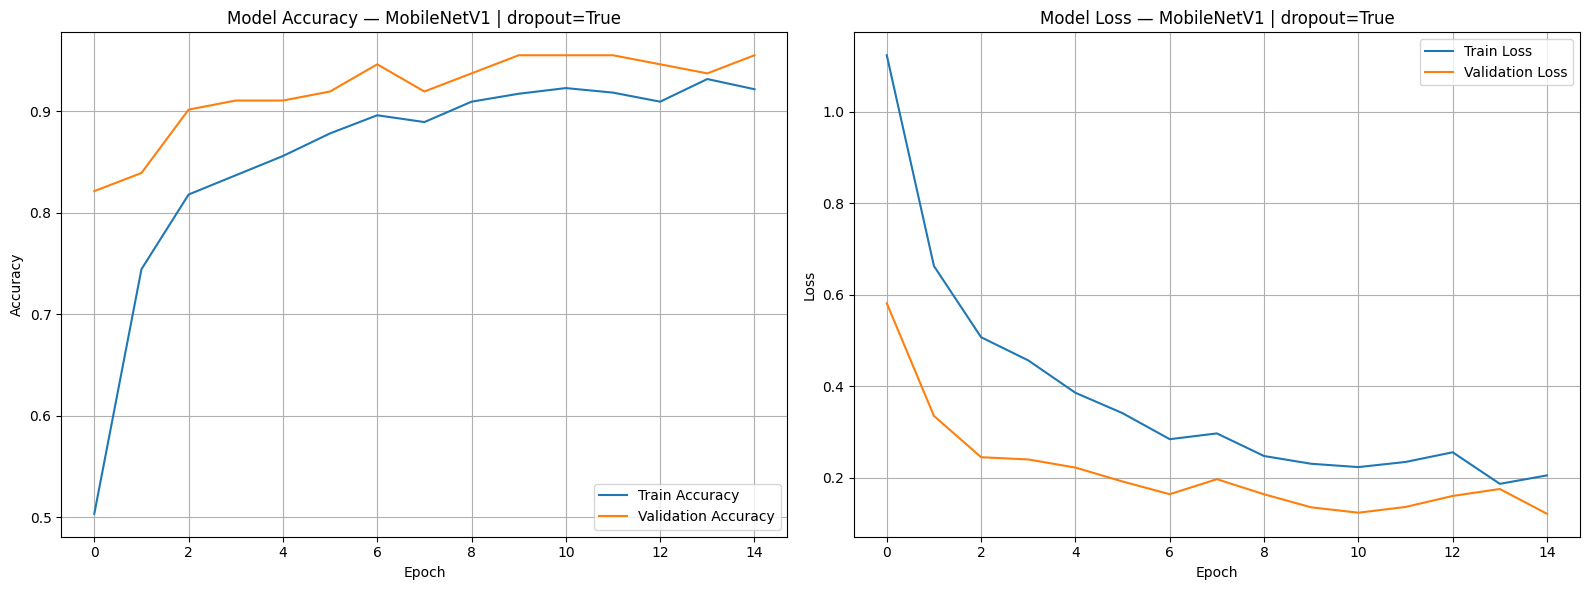

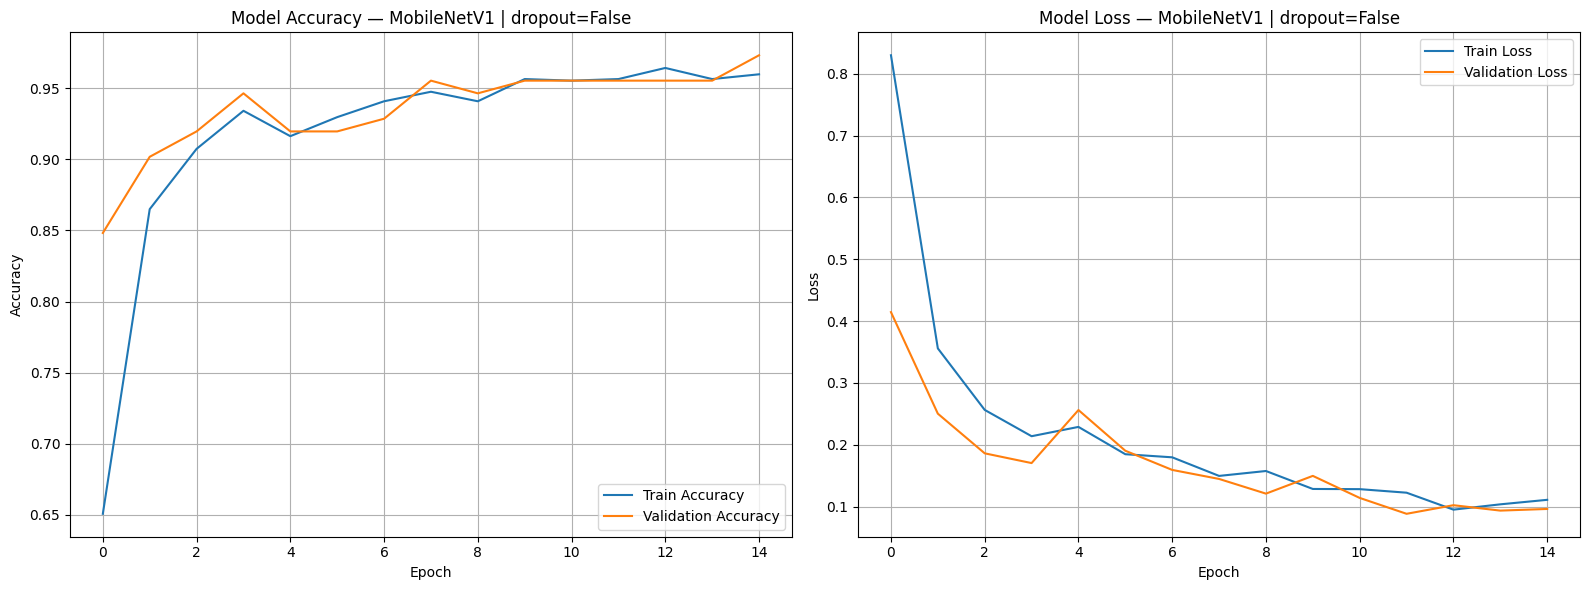

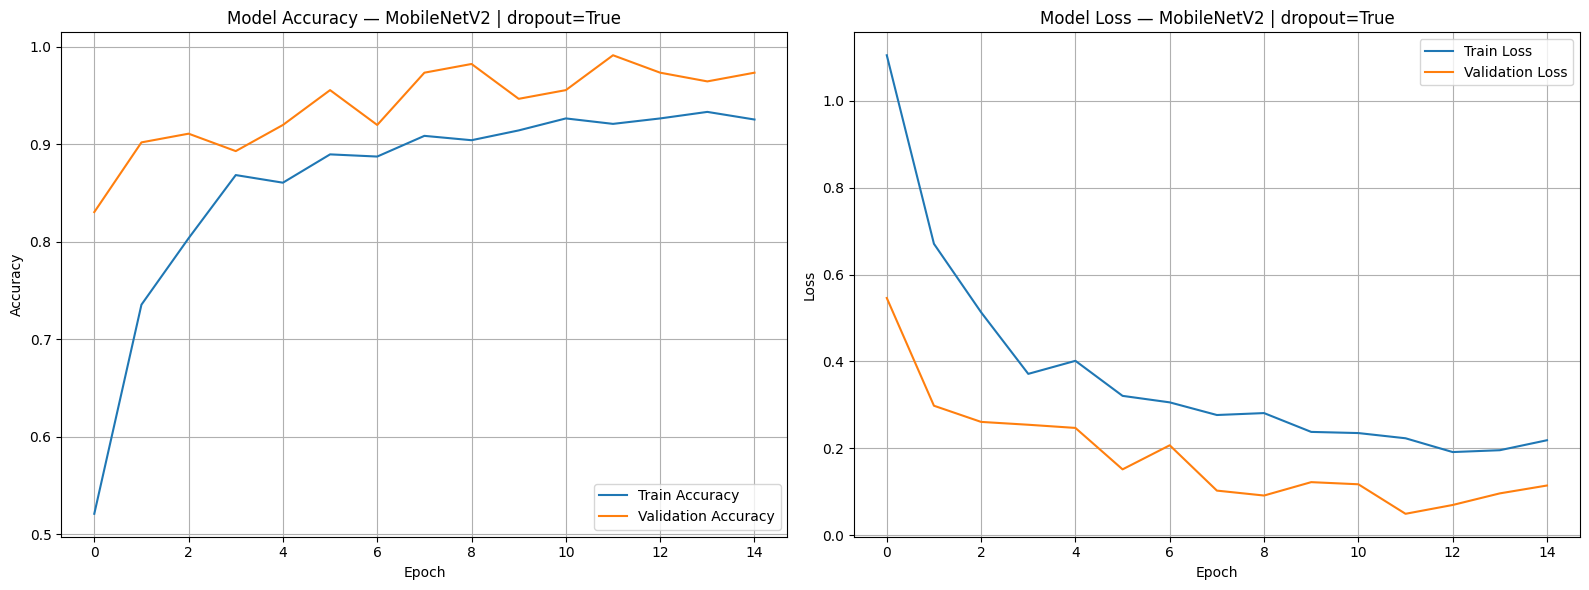

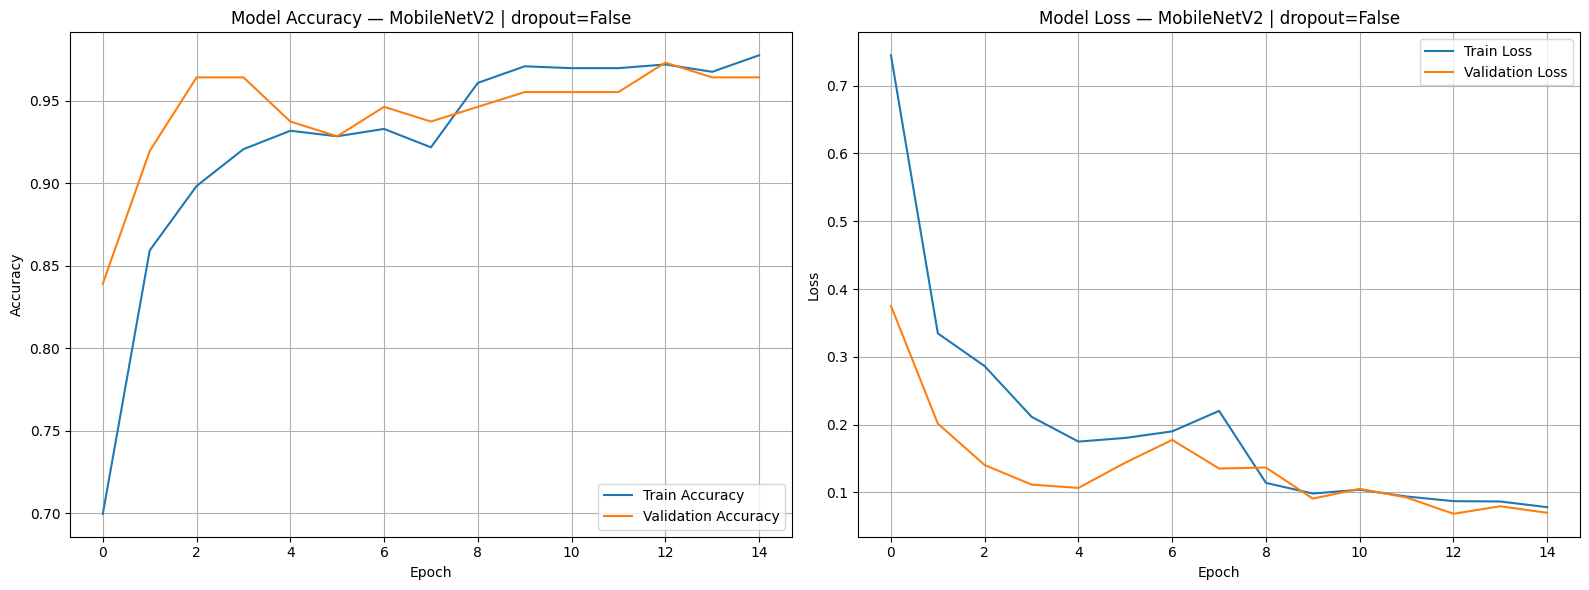

In [23]:
# membuat grafik accuracy dan loss
for res in results:
    h = res['history']
    label = f"{res['model_type']} | dropout={res['use_dropout']}"
    plt.figure(figsize=(16,6))

    # Accuracy Training plot
    plt.subplot(1, 2, 1)
    plt.plot(h['accuracy'], label='Train Accuracy')
    plt.plot(h['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Model Accuracy — {label}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

    # Loss Training plot
    plt.subplot(1, 2, 2)
    plt.plot(h['loss'], label='Train Loss')
    plt.plot(h['val_loss'], label='Validation Loss')
    plt.title(f"Model Loss — {label}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# **TESTING MODEL**

In [24]:
# Siapkan test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',
    batch_size=32,
    target_size=target_size,
    class_mode='categorical',
    shuffle=False
)

# inisialisasi untuk menyimpan hasil test
test_results = []
for r in results:
    params = {
        'model_type' : r['model_type'],
        'use_dropout': r['use_dropout']
    }
    print(f"\n--- Evaluating on test set: {params} ---")

    # ambil model yang sudah disimpan
    model = r['model']

    start_eval = time.time()
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    eval_duration = time.time() - start_eval

    test_results.append({
        **params,
        'test_accuracy'     : test_acc,
        'test_loss'         : test_loss,
        'duration'          : round(eval_duration, 2)
    })

# ringkas hasil ke DataFrame dan cetak
df_test_results = pd.DataFrame(test_results).sort_values('test_accuracy', ascending=False, ignore_index=True)

print(df_test_results)

# download .csv
df_test_results.to_csv('test_results.csv', index=False)

Found 112 images belonging to 4 classes.

--- Evaluating on test set: {'model_type': 'MobileNetV1', 'use_dropout': True} ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9530 - loss: 0.1176

--- Evaluating on test set: {'model_type': 'MobileNetV1', 'use_dropout': False} ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9555 - loss: 0.1057

--- Evaluating on test set: {'model_type': 'MobileNetV2', 'use_dropout': True} ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9097 - loss: 0.1639

--- Evaluating on test set: {'model_type': 'MobileNetV2', 'use_dropout': False} ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9680 - loss: 0.0848
    model_type  use_dropout  test_accuracy  test_loss  duration
0  MobileNetV1        False       0.964286   0.099451     16.66
1  MobileNetV2        False       0.964286   0.093598     14.64
2  MobileNetV1         True       0.955357   0.108055     15.37
3  MobileNetV2         True       0.901786   0.189728     15.79


# **Evaluasi Model**


=== Evaluating Confusion Matrix & Report for MobileNetV1_dropout ===


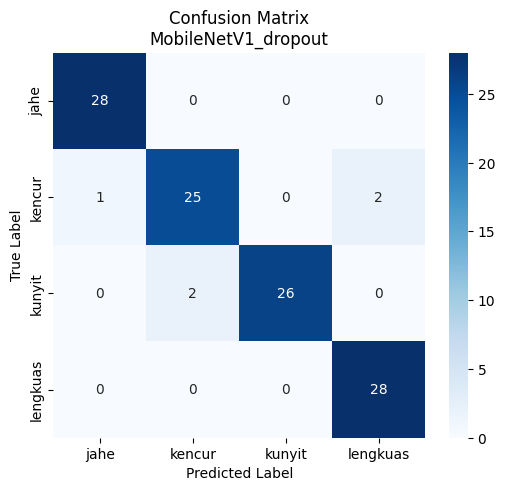

Classification Report:
              precision    recall  f1-score   support

        jahe       0.97      1.00      0.98        28
      kencur       0.93      0.89      0.91        28
      kunyit       1.00      0.93      0.96        28
    lengkuas       0.93      1.00      0.97        28

    accuracy                           0.96       112
   macro avg       0.96      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112


=== Evaluating Confusion Matrix & Report for MobileNetV1_no_dropout ===


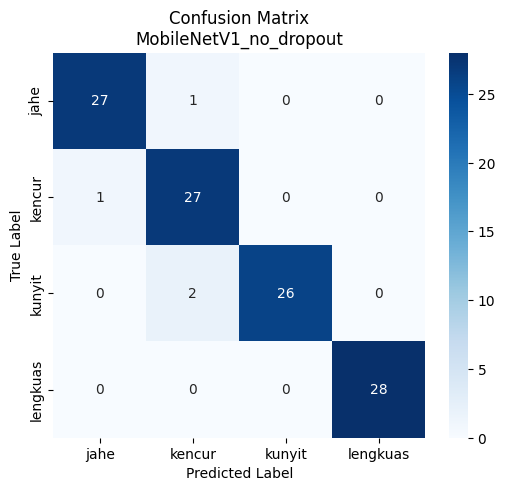

Classification Report:
              precision    recall  f1-score   support

        jahe       0.96      0.96      0.96        28
      kencur       0.90      0.96      0.93        28
      kunyit       1.00      0.93      0.96        28
    lengkuas       1.00      1.00      1.00        28

    accuracy                           0.96       112
   macro avg       0.97      0.96      0.96       112
weighted avg       0.97      0.96      0.96       112


=== Evaluating Confusion Matrix & Report for MobileNetV2_dropout ===


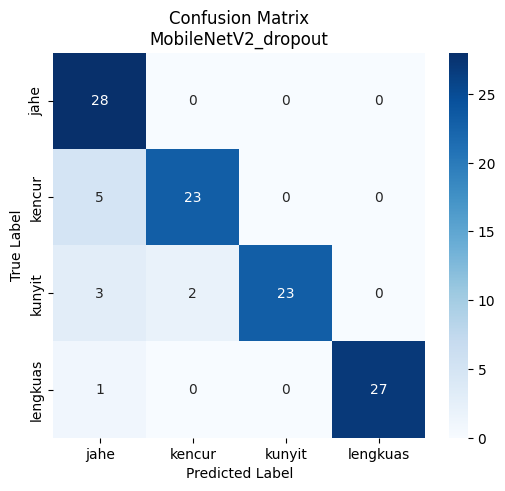

Classification Report:
              precision    recall  f1-score   support

        jahe       0.76      1.00      0.86        28
      kencur       0.92      0.82      0.87        28
      kunyit       1.00      0.82      0.90        28
    lengkuas       1.00      0.96      0.98        28

    accuracy                           0.90       112
   macro avg       0.92      0.90      0.90       112
weighted avg       0.92      0.90      0.90       112


=== Evaluating Confusion Matrix & Report for MobileNetV2_no_dropout ===


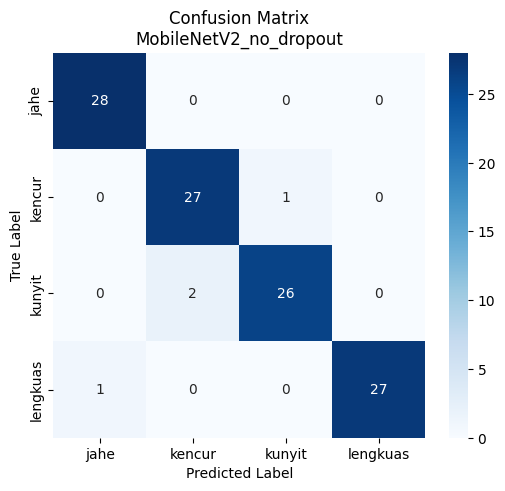

Classification Report:
              precision    recall  f1-score   support

        jahe       0.97      1.00      0.98        28
      kencur       0.93      0.96      0.95        28
      kunyit       0.96      0.93      0.95        28
    lengkuas       1.00      0.96      0.98        28

    accuracy                           0.96       112
   macro avg       0.96      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112



In [25]:
# Ambil daftar label (string)
class_labels = list(test_generator.class_indices.keys())

for r in results:
    name  = r['model_name']
    model = r['model']

    print(f"\n=== Evaluating Confusion Matrix & Report for {name} ===")

    # Reset generator agar predict/evaluate konsisten
    test_generator.reset()

    # Model predict
    y_prob = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_generator.classes

    # Membuat Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f"Confusion Matrix\n{name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Membuat Classification report
    report = classification_report(
        y_true, y_pred,
        target_names=class_labels
    )
    print("Classification Report:")
    print(report)

####**Visualisasi Gambar Test**

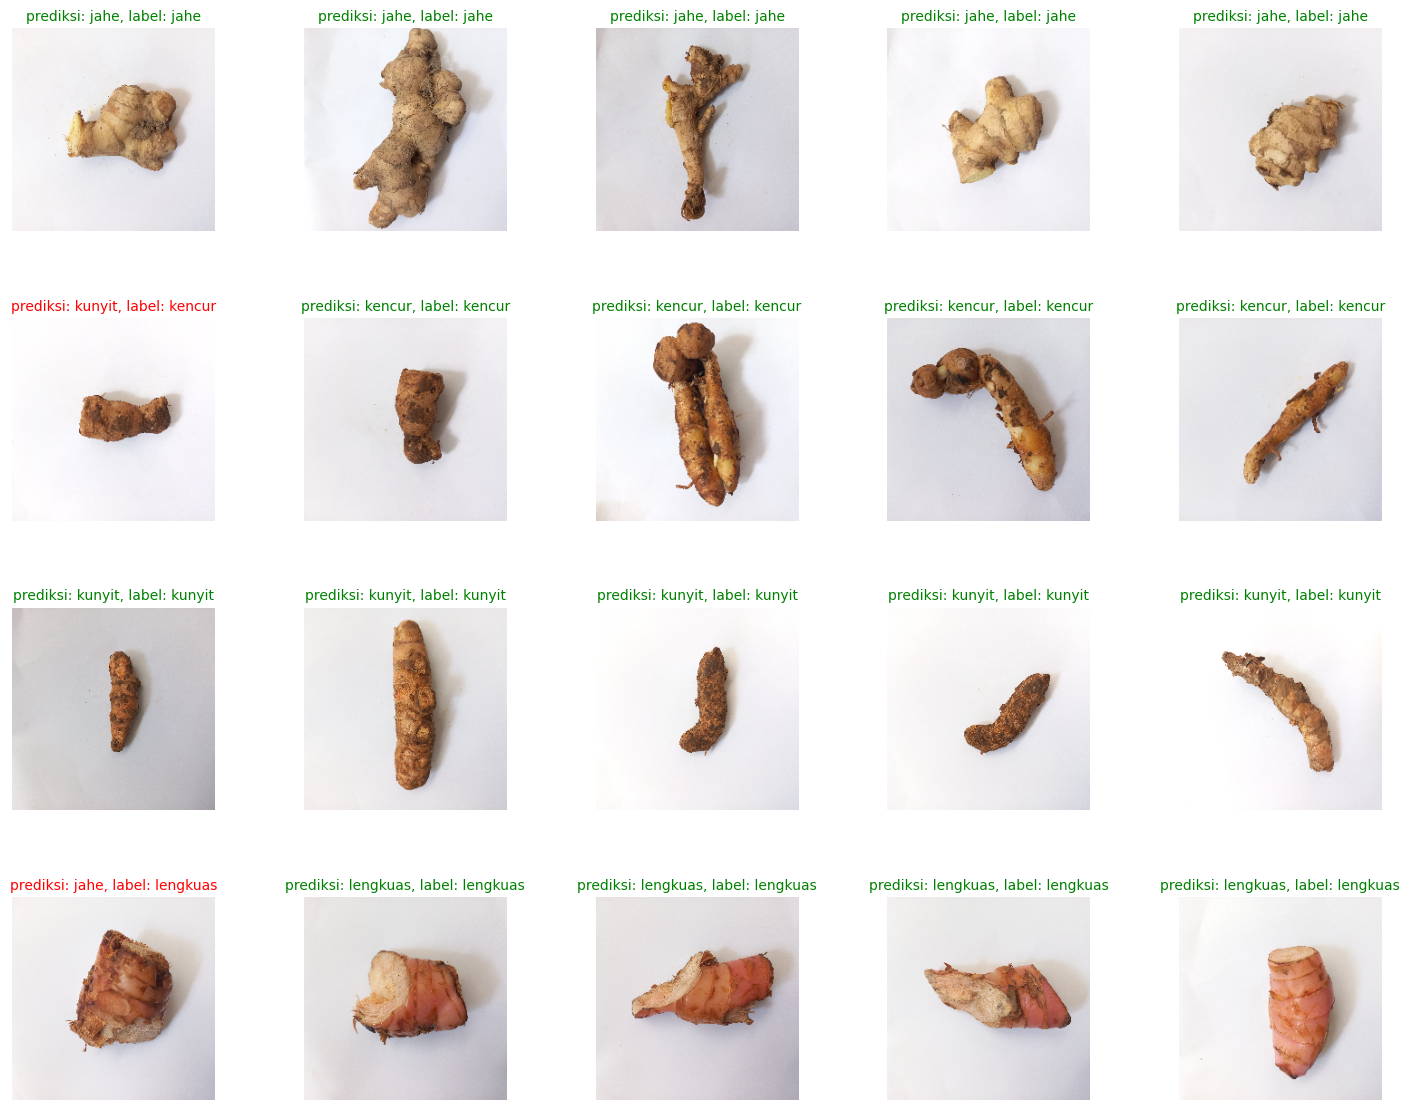

In [31]:
# Inisialisasi dict untuk menampung (img, y_true, y_pred) per kelas
samples_per_class = {label: [] for label in class_labels}

# Reset generator agar prediksi dan loop konsisten
test_generator.reset()

# Loop batch demi batch, ambil prediksi sekaligus
for x_batch, y_batch in test_generator:
    y_true_batch = np.argmax(y_batch, axis=1)
    y_prob_batch = r['model'].predict(x_batch, verbose=0)
    y_pred_batch = np.argmax(y_prob_batch, axis=1)

    for img, y_true, y_pred in zip(x_batch, y_true_batch, y_pred_batch):
        cls_true = class_labels[y_true]
        # kumpulkan maksimum 5 sampel per kelas
        if len(samples_per_class[cls_true]) < 5:
            samples_per_class[cls_true].append((img, y_true, y_pred))
    # Stop jika tiap kelas sudah dapat 5 sampel
    if all(len(v) >= 5 for v in samples_per_class.values()):
        break

# Plot grid: baris = kelas, kolom = 5 sampel
n_classes = len(class_labels)
fig, axes = plt.subplots(n_classes, 5, figsize=(15, 3 * n_classes))
fig.tight_layout(pad=3.0)

for row, cls_true in enumerate(class_labels):
    for col in range(5):
        ax = axes[row, col] if n_classes > 1 else axes[col]
        img, y_true, y_pred = samples_per_class[cls_true][col]
        ax.imshow(img)
        ax.axis('off')

        # teks prediksi dan label asli
        pred_label = class_labels[y_pred]
        title = f"prediksi: {pred_label}, label: {cls_true}"
        # warna hijau kalau tepat, merah kalau salah
        color = 'green' if (y_true == y_pred) else 'red'
        ax.set_title(title, color=color, fontsize=10)

plt.show()

# **Save Model**

In [32]:
# save best_model
for r in results:
    if r['model_type'] == 'MobileNetV2' and r['use_dropout'] == False:
        best_model = r['model']
        best_name  = r['model_name']
        break

# Simpan full model ke HDF5
best_model.save(f"{best_name}.h5")
print(f"Saved model to {best_name}.h5")

Saved model to MobileNetV2_no_dropout.h5


In [33]:
for r in results:
    m   = r['model']
    name = r['model_name']
    # full model
    m.save(f"{name}.h5")

# **Prediction**

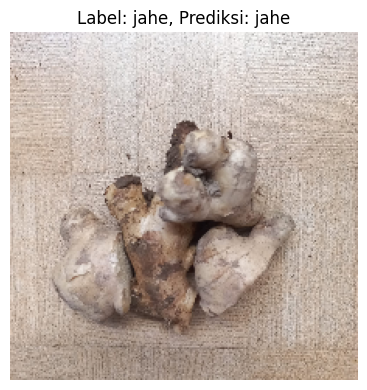

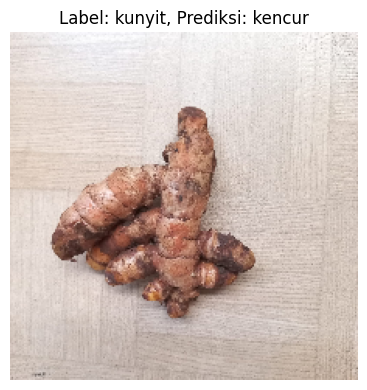

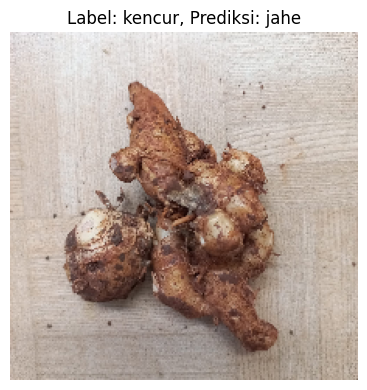

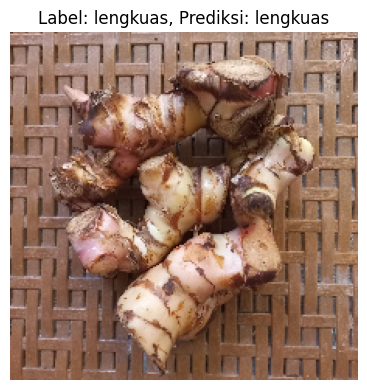

In [34]:
MODEL_PATH     = "MobileNetV2_no_dropout.h5"
CLASS_MAPPING  = {0: 'jahe', 1: 'kencur', 2: 'kunyit', 3: 'lengkuas'}
TARGET_SIZE    = (224, 224)
SAMPLE_IMAGES  = ["jahe.jpeg", "kunyit.jpeg", "kencur.jpeg", "lengkuas.jpeg"]

# Load model
model = load_model(MODEL_PATH)

def predict_and_show(img_path):
    # Definisikan label asli
    true_label = os.path.splitext(os.path.basename(img_path))[0]

    # Load & preprocess
    img = load_img(img_path, target_size=TARGET_SIZE)
    arr = img_to_array(img) / 255.0
    batch = np.expand_dims(arr, axis=0)

    # Predict
    probs = model.predict(batch, verbose=0)[0]
    idx_pred = np.argmax(probs)
    pred_label = CLASS_MAPPING[idx_pred]
    confidence = probs[idx_pred]

    # Show
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(f"Label: {true_label}, Prediksi: {pred_label}")
    plt.tight_layout()
    plt.show()

# Loop dan tampilkan
for img_path in SAMPLE_IMAGES:
    if os.path.exists(img_path):
        predict_and_show(img_path)
    else:
        print(f"File {img_path} tidak ditemukan, dilewati.")

In [ ]:
pip freeze > requirements.txt